In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report




In [10]:
transform_train = transforms.Compose( [ transforms.RandomResizedCrop(256, scale=(0.9, 1.0)), transforms.RandomHorizontalFlip(p=0.5), 
                                       transforms.RandomRotation(15), 
                                        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ] )  

transform_test = transforms.Compose( [ transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
transform_valid = transforms.Compose( [ transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
#the normalize tool maps image values from [0,1] to [-1, 1] which is standard for deep learning models 
#Compose combines multiple image transformstions sequentially 
#ToTensor converts PIL image values (0-255) to pytorch tensors(0-1)
#Normalize normalizes each rgb channel where mean=0.5 and std=0.5 (pixel = (pixel-mean)/std). now it maps the pixel values from [0,1] to [-1,1]


In [11]:
train_data = datasets.ImageFolder(root=r'E:\Honey\Fun\cancer detection using sam 2\code\Data\train', transform=transform_train) 
test_data = datasets.ImageFolder(root=r'E:\Honey\Fun\cancer detection using sam 2\code\Data\test', transform=transform_test) 
val_data = datasets.ImageFolder(root=r'E:\Honey\Fun\cancer detection using sam 2\code\Data\valid', transform=transform_valid) 
#loading the training, test and validation data using imagefolder 

In [12]:
train_loader = DataLoader(train_data, batch_size=50, shuffle=True) 
test_loader = DataLoader(test_data, batch_size=50, shuffle=False) 
val_loader = DataLoader(val_data, batch_size=50, shuffle=False) 
#creating data loaders to load images in batches of 50

print(train_data.classes) 
num_classes = len(train_data.classes)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [13]:
import matplotlib.pyplot as plt 
import numpy as np 
import torchvision 

def imshow(img):                                                        #function to unnormalize and display images
    img = img/2 + 0.5                                                   #unnormalizes the images and converts the tensors from [-1,1] to [0,1]
    npimg = img.numpy()                                                 #converts tensors to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))                          #transpose swaps axises from (C,H,W) to (H,W,C)
    plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


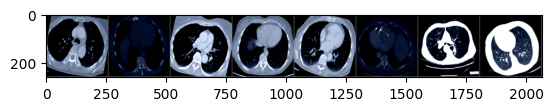

Labels:  ['large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal']


In [14]:
dataiter = iter(train_loader)                                           #creates an iterator for training images
images, labels = next(dataiter)                                         #gets a batch of images and labels

imshow(torchvision.utils.make_grid(images[:8]))                             #combines multiple images into a single grid (8) and displays them
print('Labels: ', [train_data.classes[i] for i in labels[:8]])                    #prints image labels of the 8 images

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [16]:
model = models.densenet121(weights = "IMAGENET1K_V1") 

for param in model.features[:6].parameters(): 
    param.requires_grad = False 

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes) 

model = model.to(device) 

In [17]:
class_weights = torch.tensor([2.625, 6.176, 5.833, 3.500])

criterion = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2)

In [18]:
num_epochs = 20 

for epoch in range(num_epochs): 
    model.train() 
    train_loss = 0.0 
    train_total = 0.0 
    train_correct = 0.0 

    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad() 
        outputs = model(images) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step() 
        
        train_loss += loss.item() 
        _, preds = torch.max(outputs, 1) 
        train_total += labels.size(0) 
        train_correct += (preds==labels).sum().item() 
         
    train_acc = 100*train_correct / train_total 
    train_loss /= len(train_loader) 



    model.eval() 
    val_correct=0.0 
    val_total=0.0 
    val_loss=0.0 

    with torch.no_grad(): 
        for images, labels in val_loader: 
            images, labels = images.to(device), labels.to(device) 
            outputs=model(images) 
            loss = criterion(outputs, labels) 

            val_loss += loss.item() 
            _, predicted = outputs.max(1) 
            val_total += labels.size(0) 
            val_correct += predicted.eq(labels).sum().item() 

    val_acc = 100*val_correct/val_total 
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch: [{epoch+1}/{num_epochs}]     training loss: {train_loss:.4f}     training accuracy: {train_acc:.2f}%     validation loss: {val_loss:.4f}     validation accuracy: {val_acc:.2f}%")

Epoch: [1/20]     training loss: 0.9516     training accuracy: 52.20%     validation loss: 0.8244     validation accuracy: 50.00%
Epoch: [2/20]     training loss: 0.5953     training accuracy: 74.55%     validation loss: 0.7384     validation accuracy: 47.22%
Epoch: [3/20]     training loss: 0.3783     training accuracy: 86.46%     validation loss: 0.6553     validation accuracy: 65.28%
Epoch: [4/20]     training loss: 0.2625     training accuracy: 92.01%     validation loss: 0.6015     validation accuracy: 69.44%
Epoch: [5/20]     training loss: 0.1617     training accuracy: 97.06%     validation loss: 0.6248     validation accuracy: 76.39%
Epoch: [6/20]     training loss: 0.1097     training accuracy: 98.21%     validation loss: 0.5538     validation accuracy: 79.17%
Epoch: [7/20]     training loss: 0.0750     training accuracy: 98.86%     validation loss: 0.4177     validation accuracy: 84.72%
Epoch: [8/20]     training loss: 0.0494     training accuracy: 99.51%     validation loss: